#### 과제 가이드라인

- 2주차 과제 제출에 포함되어야 하는 형태 (최소)
- 모델링에 대한 결과 .ipynb 파일 (team1_onboarding_week2_analysis.ipynb)
- np.random.seed(42) 설정
- Input : X데이터 : [user_id, +@]
- Output : Count column 예측값
- 2020.01.01~2020.09.30 : Training Data
- 2020.10.01~2020.12.31 : Test Data
- 2020.10.01~2020.12.31 구간에 대한 MSE, MAE 계산값
- 요일별 이용량에 대한 분석 - EDA
- **유저별 이용 count 값에 대한 분석 - EDA**

#### 모두 컴퍼니
- 회사 기본 정보
- 비즈니스 모델
- 데이터 분석 목표

> data : 유저 ID, 일자별 결제 내역 데이터 

#### 모듈 import

In [1]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style(style="white")
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.unicode_minus'] = False    # minus

# interactive
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

#### 데이터 로드 
- 원본 데이터 셋 modu > df
- 외부 데이터 weather, traffic

##### 기본 변수

In [2]:
modu = pd.read_csv('../week2/실전db.csv')
df = modu.copy() # 분석 데이터 셋
df.head()

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [3]:
modu.DATE

0         2020-01-01
1         2020-01-01
2         2020-01-01
3         2020-01-01
4         2020-01-01
             ...    
879266    2020-12-31
879267    2020-12-31
879268    2020-12-31
879269    2020-12-31
879270    2020-12-31
Name: DATE, Length: 879271, dtype: object

##### 외부 변수
- 날씨 / 교통량
- 공휴일정보

In [4]:
weather = pd.read_csv('../week2/서울시_기상데이터.csv', encoding='cp949')
traffic = pd.read_excel('../week2/2020교통량통합.xlsx')

In [5]:
weather.head(2)  # 일자별 강수량

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1


In [6]:
traffic.head(2)   # 일자별, 시간별 교통량

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0


In [23]:
df_holiday =pd.read_excel('holiday_master.xlsx')
df_holiday.head(2)

,date,isholiday,exp
0,2020-01-01,holiday,새해
1,2020-01-02,weekdays,평일


### 데이터 개요

In [7]:
df.shape

(879271, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     879271 non-null  int64 
 1   JOIN_DATE   879271 non-null  object
 2   D_TYPE      879271 non-null  object
 3   STORE_ID    879271 non-null  int64 
 4   GOODS_TYPE  879271 non-null  object
 5   DATE        879271 non-null  object
 6   COUNT       879271 non-null  int64 
 7   AD1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


##### 컬럼 소문자변환

In [9]:
df.columns=list(map(lambda x: x.lower(),df.columns))

##### Date 변수 변환

In [13]:
df['date']=pd.to_datetime(df['date'])
df['join_date']=pd.to_datetime(df['join_date'])

In [10]:
weather['일시']=pd.to_datetime(weather['일시'])

##### 컬럼 추가 : year month day dayofweek quarter hour minute


In [14]:
df['year'] = df['date'].dt.year             # 년도
df['month'] = df['date'].dt.month           # 월
df['day'] = df['date'].dt.day               # 일자
df['dayofweek'] = df['date'].dt.dayofweek   # 요일 : 0-6
df['quarter'] = df['date'].dt.quarter       # 분기

In [15]:
df['date']

0        2020-01-01
1        2020-01-01
2        2020-01-01
3        2020-01-01
4        2020-01-01
            ...    
879266   2020-12-31
879267   2020-12-31
879268   2020-12-31
879269   2020-12-31
879270   2020-12-31
Name: date, Length: 879271, dtype: datetime64[ns]

In [16]:
df.head(1)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2020,1,1,2,1


In [17]:
df.shape

(879271, 13)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     879271 non-null  int64         
 1   join_date   879271 non-null  datetime64[ns]
 2   d_type      879271 non-null  object        
 3   store_id    879271 non-null  int64         
 4   goods_type  879271 non-null  object        
 5   date        879271 non-null  datetime64[ns]
 6   count       879271 non-null  int64         
 7   ad1         879271 non-null  object        
 8   year        879271 non-null  int64         
 9   month       879271 non-null  int64         
 10  day         879271 non-null  int64         
 11  dayofweek   879271 non-null  int64         
 12  quarter     879271 non-null  int64         
dtypes: datetime64[ns](2), int64(8), object(3)
memory usage: 87.2+ MB


In [19]:
df.isna().sum()

user_id       0
join_date     0
d_type        0
store_id      0
goods_type    0
date          0
count         0
ad1           0
year          0
month         0
day           0
dayofweek     0
quarter       0
dtype: int64

In [20]:
print('데이터 기간 :', df['date'].min() ,"~", df['date'].max())

데이터 기간 : 2020-01-01 00:00:00 ~ 2020-12-31 00:00:00


##### 컬럼추가 : isholiday

In [24]:
df_holiday['isholiday'] = np.where(df_holiday.isholiday=='holiday',1,0)
df_holiday.head()

,date,isholiday,exp
0,2020-01-01,1,새해
1,2020-01-02,0,평일
2,2020-01-03,0,평일
3,2020-01-04,1,주말
4,2020-01-05,1,주말


In [25]:
# 공휴일 변수 추가 
df = df.merge(df_holiday[['date','isholiday']], on='date')

### EDA
***:필수**
> 시계열 자료 
> https://otexts.com/fppkr/tspatterns.html

> Feature selection & generation
> - 요일, 날짜
> - 유저별 연간이용횟수 
> - 유저그룹별 Retention
> - 교통량 (성규, 준식)
> - 기상 (동섭, 지인, 낙주)

#### User 이용횟수
- 결제횟수별
- 연간이용횟수

##### 결제 횟수 (count)

In [26]:
print('전체 유저 수 :', df['user_id'].nunique())

전체 유저 수 : 165425


In [27]:
df.groupby('user_id')['count'].sum().sort_values(ascending=False)

user_id
999665     7919
1514190     284
591610      245
1467323     239
1355841     235
           ... 
1023974       1
1551355       1
1024027       1
1024047       1
1830598       1
Name: count, Length: 165425, dtype: int64

In [28]:
df.groupby('user_id')['count'].sum().describe()

count    165425.000000
mean          5.469784
std          22.823610
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        7919.000000
Name: count, dtype: float64

- 유저별 연간 결제횟수 중위값 2 
- 유저별 연간 결제횟수 평균 5

- **유저별 편차 크다**

##### 연간 이용 횟수 (freq)
- 유저별 연간이용횟수

In [29]:
# df_user, df_user_freq
eng = df.groupby(['user_id'])['date'].count().values
users = df.groupby(['user_id'])['date'].count().index
df_user = pd.DataFrame(eng,users).reset_index().rename(columns={0:'freq'})
df_user_freq = df_user.groupby('freq')['user_id'].count().reset_index().rename(columns={'user_id':'count'})

In [30]:
# 분석 데이터셋에 유저별 이용횟수 merge : freq:: 전체기간동안 총 이용횟수
df = df.merge(df_user, on='user_id', how='left')

In [31]:
df.head(1)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter,isholiday,freq
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2020,1,1,2,1,1,1


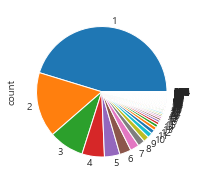

In [32]:
df_user_freq.set_index('freq').plot(kind='pie',y='count', figsize=(5,3), legend=False)

In [33]:
df_user_freq.set_index('freq').T

freq,1,2,3,4,5,6,7,8,9,10,...,199,201,207,209,210,213,222,235,244,366
count,74889,26675,14432,9185,6338,4717,3673,2860,2357,2002,...,2,1,2,1,1,1,3,1,1,1


In [34]:
df.freq.describe()

count    879271.000000
mean         30.947234
std          38.325563
min           1.000000
25%           5.000000
50%          16.000000
75%          43.000000
max         366.000000
Name: freq, dtype: float64

**평균 30, 중위값 16 차이 큰 편 : 유저별 이용빈도 차이 크다**
> - 이용빈도 class별 ?
> - 이용빈도 1회 <-> 그 외 (returning) ?

- 이용횟수 최대 366 : 1년 내내이용 > d_type only CC : 주거지 주차 공유?

In [35]:
print('1년내내 이용 : ', df.query('freq==366')['user_id'].unique(),'\nd_type : ', df.query('freq==366')['d_type'].unique(),
     '\nstore_id : 다양함', #df.query('freq==366')['store_id'].unique(), 
    '\ngoods_type : ', df.query('freq==366')['goods_type'].unique()    )

1년내내 이용 :  [999665] 
d_type :  ['CC'] 
store_id : 다양함 
goods_type :  ['A' 'D' 'C']


In [36]:
print('200일 이상 이용 : ', df.query('freq>200')['user_id'].unique(),
      '\nd_type :\n', df.query('freq>200')['d_type'].value_counts(sort=True),
     #'store_id :', df.query('freq==366')['store_id'].unique(), 
    '\ngoods_type :\n ', df.query('freq>200')['goods_type'].value_counts(),
    '\ndayofweek :\n',df.query('freq>200')['dayofweek'].value_counts())

200일 이상 이용 :  [ 999665  591610  612237 1144500 1224426 1355841 1201981 1365069 1407916
 1284291  909315 1504815] 
d_type :
 AA    1754
BB     638
CC     366
Name: d_type, dtype: int64 
goods_type :
  A    2608
C      84
B      40
D      26
Name: goods_type, dtype: int64 
dayofweek :
 1    504
0    492
2    485
3    479
4    447
5    213
6    138
Name: dayofweek, dtype: int64


In [37]:
print('200일 이상 이용 : ', df.query('freq==1')['user_id'].unique(),
      '\nd_type : ', df.query('freq==1')['d_type'].value_counts(sort=True),
     #'store_id :', df.query('freq==366')['store_id'].unique(), 
    '\ngoods_type :\n', df.query('freq==1')['goods_type'].value_counts(sort=True),
    '\ndayofweek :\n',df.query('freq==1')['dayofweek'].value_counts())

200일 이상 이용 :  [   2858   80936   83850 ... 1830580 1830589 1830598] 
d_type :  AA    43004
BB    31727
CC      158
Name: d_type, dtype: int64 
goods_type :
 A    40387
C    17427
B    14275
D     2800
Name: goods_type, dtype: int64 
dayofweek :
 5    19563
6    12193
4    11657
3     8844
2     8097
1     7730
0     6805
Name: dayofweek, dtype: int64


**이용빈도가 높을수록 평일에 집중되어 있음**

###### 연간 이용횟수별로 요일/Categorical 차이?

> **연간 이용횟수 1회인 유저 VS 연간 이용횟수 30회(평균)이상 유저**

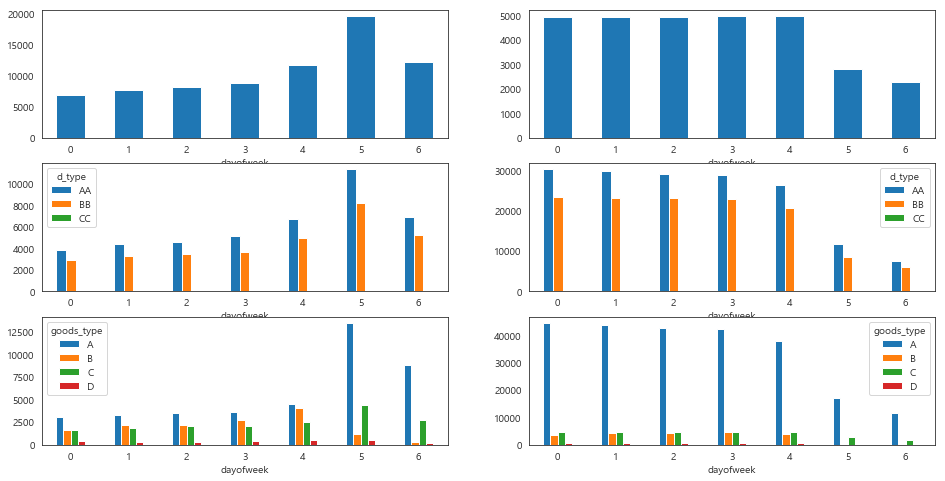

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(16,8))
df.query('freq==1').groupby('dayofweek')['user_id'].nunique().plot(kind='bar',rot=0, ax=axes[0,0])
df.query('freq==1').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[1,0])
df.query('freq==1').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[2,0])
df.query('freq>30').groupby('dayofweek')['user_id'].nunique().plot(kind='bar',rot=0, ax=axes[0,1])
df.query('freq>30').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[1,1])
df.query('freq>30').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[2,1])

**연간 이용횟수 1회인 유저**
- 1회인 유저는 주로 토요일 집중(대세와 일치)

**30회(평균)이상인 유저**
- 평일에 집중
- goods_type A에 집중 > A가 평일 당일권이 아닐까?
- goods_type:D 거의 없음


**공통 특징: d_type CC없음**

> **연간 이용횟수 46회이상인 유저(상위 25%)**

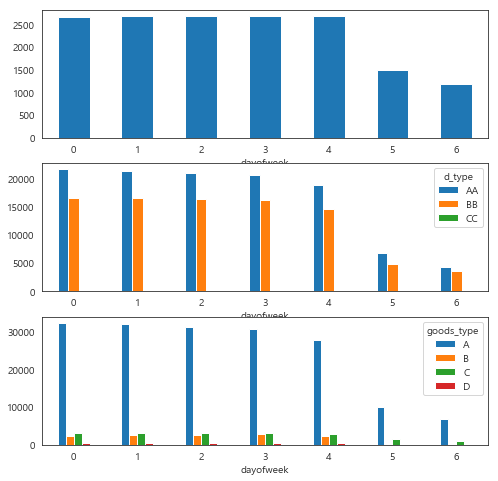

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,8))
df.query('freq>=46').groupby('dayofweek')['user_id'].nunique().plot(kind='bar',rot=0, ax=axes[0])
df.query('freq>=46').pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[1])
df.query('freq>=46').pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[2])

###### 연간 이용횟수 클래스 나눠 분석?

In [40]:
# 3개 클래스로 분류
df_user_freq['class_freq'] = pd.qcut(df_user_freq['freq'], 5, labels=range(1,6))

In [41]:
df_user_freq.class_freq.value_counts()

1    39
2    39
4    39
5    39
3    38
Name: class_freq, dtype: int64

In [42]:
df_user_freq

,freq,count,class_freq
0,1,74889,1
1,2,26675,1
2,3,14432,1
3,4,9185,1
4,5,6338,1
...,...,...,...
189,213,1,5
190,222,3,5
191,235,1,5
192,244,1,5


In [44]:
freq1_list = list(df_user.query('freq==1')['user_id'])

#### *연간 이용횟수 (결제시점고려: freq_cum)

In [46]:
# user_id별 date별 sorting
df_l = df.sort_values(['user_id','date']).reset_index(drop=True)
df_l.head(2)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter,isholiday,freq
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,12,6,1,1,2
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,9,2,4,0,2


In [47]:
# lead > shift(-1)
# user_id별 다음 이용일자 정보
df_l['next'] = df_lead.sort_values(['user_id','date']).groupby('user_id')['date'].shift(-1)
df_l.head(2)

NameError: name 'df_lead' is not defined

In [ ]:
# lag > shift(1)
# user_id별 다음 이용일자 정보
df_l['before'] = df_lead.sort_values(['user_id','date']).groupby('user_id')['date'].shift(1)
df_l.head(2)

In [ ]:
# pd.DataFrame(df_l.groupby(['user_id','date'])['before'].count()).groupby('user_id')['before'].cumsum()[0:10]
df_l['freq_cum'] = pd.DataFrame(df_l.groupby(['user_id','date'])['before'].count()).groupby('user_id')['before'].cumsum().values
df_l.head(5)

In [ ]:
# 2020-10-01 이전 시점 
df_l['freq_cum_sum'] = df_l.query('date<"2020-10-01"').groupby('user_id')['freq_cum'].sum()
df_l.head()

In [ ]:
df_l.groupby(['user_id','date']).

In [48]:
df_l

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter,isholiday,freq
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,12,6,1,1,2
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,9,2,4,0,2
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2020,1,19,6,1,1,23
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2020,1,26,6,1,1,23
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2020,1,27,0,1,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020,12,31,3,4,0,1
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020,12,31,3,4,0,1
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020,12,31,3,4,0,1
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020,12,31,3,4,0,1


#### 요일, 날짜별

##### 요일별 결제횟수, 이용자 수

#count by 
 dayofweek
0    130447
1    134288
2    136034
3    137323
4    141837
5    135906
6     89004
Name: count, dtype: int64
#user_id by 
 dayofweek
0    130447
1    134288
2    136034
3    137323
4    141837
5    135906
6     89004
Name: count, dtype: int64


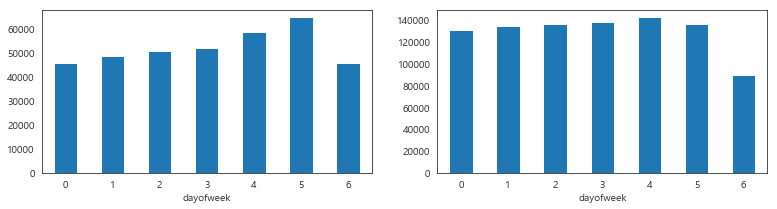

In [49]:
print('#count by \n',df.groupby('dayofweek')['count'].sum())
print('#user_id by \n',df.groupby('dayofweek')['count'].sum())
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,3))
df.groupby('dayofweek')['user_id'].nunique().plot.bar(rot=0, ax=axes[0])
df.groupby('dayofweek')['count'].sum().plot.bar(rot=0, ax=axes[1])

- 결제 횟수 : 금토 증가, 일요일 현저히 count 낮음
- 이용자 수 : 일요일 현저히 user 낮으나, 요일별 편차 크지 않음
- **주말이라고 이용자 수가 늘어나지 않는다 > 계속 어플 이용하던 사람이 이용함**

##### 월별 결제횟수, 이용자 수

##### Categorical
https://www.moduparking.com/service/%ec%a3%bc%ec%b0%a8%ea%b6%8c-%ec%9d%b4%ec%9a%a9%ec%95%88%eb%82%b4/
- 주차공유 type : 공유주차장/주거지주차공유/사유지주차공간공유 
- 주차권 type : 평일당일권/3시간권/평일심야권/휴일당일권

In [50]:
df['goods_type'].value_counts()

A    609790
C    131163
B    118541
D     19777
Name: goods_type, dtype: int64

In [51]:
df['d_type'].value_counts()

AA    493166
BB    384541
CC      1564
Name: d_type, dtype: int64

- user 당 dtype 1:1 맵핑

In [52]:
print('주차창 수: ', df['store_id'].nunique())

주차창 수:  1061


In [53]:
df['ad1'].unique()

array(['GN', 'J', 'SC', 'MP', 'JRR', 'YD', 'GJ', 'YO', 'GSN', 'GBC', 'BF',
       'DJ', '0', 'CD', 'NO', 'CY', 'YC', 'SD', 'GD', 'GSW', 'DM', 'R',
       'GB', 'GS', 'GHN', 'SB', 'IND', 'P', 'GW', 'JR', 'GEJ', 'GGY',
       'GKP', 'CAS', 'SG', 'BJG', 'BHW', 'GAY', 'GYI', 'CCA', 'PJP',
       'GGC', 'IYS', 'DB', 'GGM', 'GAS', 'WOID', 'DIV', 'AOI', 'COI',
       'GPJ', 'SOI', 'ABP', 'DOI', 'WF', 'BI', 'ZP', 'EP', 'Q', 'BO',
       'ZE', 'RRR', 'QGI', 'DSO', 'SOD', 'BOI', 'WT', 'BP', 'SP', 'CN',
       'SJV', 'SDU', 'QH', 'BUD', 'CU', 'VU', 'WAE', 'NW', 'DY', 'WH',
       'GR', 'X', 'CVB', 'ADS', 'VO'], dtype=object)

###### 이용자 수 

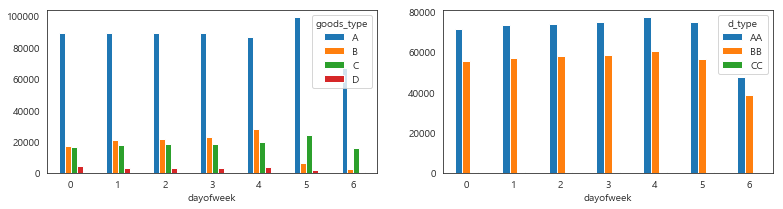

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,3))
df.pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[0])
df.pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[1])

In [55]:
df.groupby(['count','month']).count()

user_id  join_date  d_type  store_id  goods_type   date    ad1  \
count month                                                                   
1     1        52040      52040   52040     52040       52040  52040  52040   
      2        55005      55005   55005     55005       55005  55005  55005   
      3        61151      61151   61151     61151       61151  61151  61151   
      4        63494      63494   63494     63494       63494  63494  63494   
      5        68756      68756   68756     68756       68756  68756  68756   
...              ...        ...     ...       ...         ...    ...    ...   
53    11           1          1       1         1           1      1      1   
55    11           1          1       1         1           1      1      1   
58    11           1          1       1         1           1      1      1   
59    11           1          1       1         1           1      1      1   
61    11           1          1       1         1           1      1      1   

              year    day  dayofweek  quarter  isholiday   freq  
count month                                                      
1     1      52040  52040      52040    52040      52040  52040  
      2      55005  55005      55005    55005      55005  55005  
      3      61151  61151      61151    61151      61151  61151  
      4      63494  63494      63494    63494      63494  63494  
      5      68756  68756      68756    68756      68756  68756  
...            ...    ...        ...      ...        ...    ...  
53    11         1      1          1        1          1      1  
55    11         1      1          1        1          1      1  
58    11         1      1          1        1          1      1  
59    11         1      1          1        1          1      1  
61    11         1      1          1        1          1      1  

[307 rows x 13 columns]

###### 결제 횟수 (count)

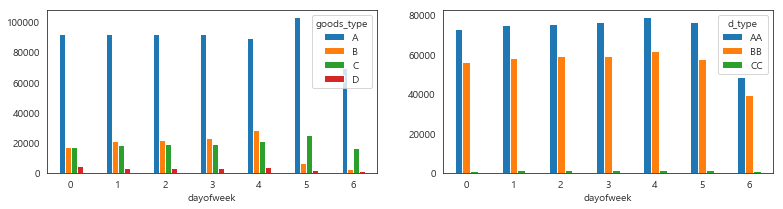

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,3))
df.pivot_table(index='dayofweek', 
               columns ='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0])
df.pivot_table(index='dayofweek', 
               columns ='d_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1])


###### 이용횟수 기준?

In [57]:
df.freq.describe()

count    879271.000000
mean         30.947234
std          38.325563
min           1.000000
25%           5.000000
50%          16.000000
75%          43.000000
max         366.000000
Name: freq, dtype: float64

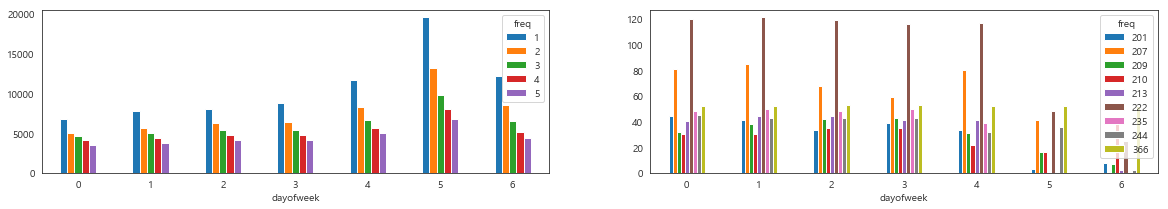

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,3))

df.query('freq<=5').pivot_table(index='dayofweek', 
               columns ='freq', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[0])
df.query('freq>=200').pivot_table(index='dayofweek', 
               columns ='freq', 
               values='user_id', 
               aggfunc='count').plot(kind='bar', rot=0, ax=axes[1])

- 이용횟수 클래스 나눠서 분석 필요

#### *Retention by order(count) date
- cohort analysis 목적 : 시간이 지남에 따라 고객 잔존율을 보고자함
- cohorts 첫 구매(count) date 월별 **유저 잔존율 / count 합계** 를 확인함

- 첫 구매 = 2020년 첫 구매

In [61]:
df_retention = df.sort_values(['user_id','date']).reset_index(drop=True).copy()

In [62]:
# 2020년 첫 구매일자
df_retention_first= pd.DataFrame(df_retention.groupby('user_id')['date'].min()).reset_index()
df_retention_first.columns=['user_id','first']
df_retention_first.head(2)

,user_id,first
0,224,2020-01-12
1,232,2020-01-19


In [63]:
# 첫구매일자정보 추가
df_retention = df_retention.merge(df_retention_first, on='user_id', how='left')
df_retention.head(4)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter,isholiday,freq,first
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,12,6,1,1,2,2020-01-12
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,9,2,4,0,2,2020-01-12
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2020,1,19,6,1,1,23,2020-01-19
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2020,1,26,6,1,1,23,2020-01-19


In [64]:
df_retention['isrepeated'] = np.where(df_retention['date'] != df_retention['first'],1,0)
df_retention.head(2)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter,isholiday,freq,first,isrepeated
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,12,6,1,1,2,2020-01-12,0
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,9,2,4,0,2,2020-01-12,1


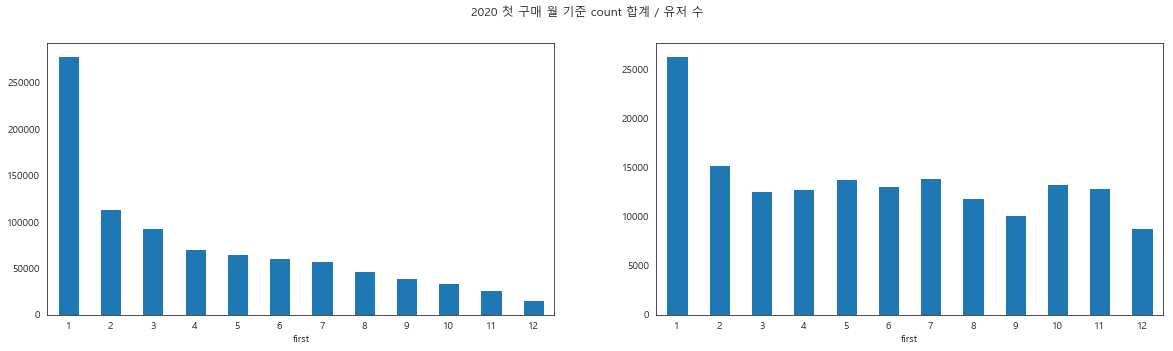

In [65]:
# first 첫 구매 월 기준 count합계 / 유저 수 
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
plt.suptitle('2020 첫 구매 월 기준 count 합계 / 유저 수')
df_retention.groupby(df_retention['first'].dt.month)['count'].sum().plot.bar(rot=0, ax=axes[0])
df_retention.groupby(df_retention['first'].dt.month)['user_id'].nunique().plot.bar(rot=0, ax=axes[1])

- 첫구매 월 1월이 제일 많음 

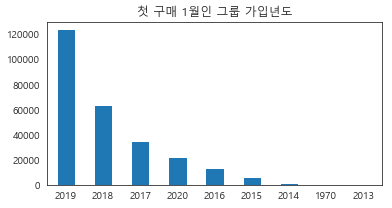

In [66]:
plt.title('첫 구매 1월인 그룹 가입년도')
df_retention.query('first.dt.month==1')['join_date'].dt.year.value_counts().plot.bar(rot=0, figsize=(6,3))

- 2020년 첫 구매 1월인 가입년도 2019년 유저 압도적 > join date도 count와 어느정도 관련 있을 것 

##### code

In [67]:
df_retention['cohort_month'] = df_retention['first'].dt.month
df_retention.head(4)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter,isholiday,freq,first,isrepeated,cohort_month
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,12,6,1,1,2,2020-01-12,0,1
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,9,2,4,0,2,2020-01-12,1,1
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2020,1,19,6,1,1,23,2020-01-19,0,1
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2020,1,26,6,1,1,23,2020-01-19,1,1


In [68]:
# 구매월
df_retention['count_month']=df_retention['date'].dt.month
df_retention.head(2)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,year,month,day,dayofweek,quarter,isholiday,freq,first,isrepeated,cohort_month,count_month
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2020,1,12,6,1,1,2,2020-01-12,0,1,1
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2020,12,9,2,4,0,2,2020-01-12,1,1,12


In [69]:
# roll up data by cohort group(첫구매월) & count_month(구매월) 
# 결제 횟수 count > sum
df_retention_cohorts = df_retention.groupby(['cohort_month', 'count_month']).agg({'user_id': pd.Series.nunique,'count': np.sum})
df_retention_cohorts = df_retention_cohorts.rename(columns={'user_id': 'total_users', 'count':'total_counts'})
df_retention_cohorts.head()

total_users  total_counts
cohort_month count_month                           
1            1                  26410         54288
             2                   9420         32183
             3                   6898         24373
             4                   7067         22262
             5                   7211         22146

In [70]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

df_retention_cohorts = df_retention_cohorts.groupby(level=0).apply(cohort_period)
df_retention_cohorts.head()

total_users  total_counts  cohort_period
cohort_month count_month                                          
1            1                  26410         54288              1
             2                   9420         32183              2
             3                   6898         24373              3
             4                   7067         22262              4
             5                   7211         22146              5

- cohort_month : 첫 구매월 기준으로 나눈 그룹
- cohort_period : 첫 구매월 이후 월

In [71]:
df_retention_cohorts.tail()

total_users  total_counts  cohort_period
cohort_month count_month                                          
10           11                  3134          8811              2
             12                  1793          5060              3
11           11                 12931         19735              1
             12                  2359          7422              2
12           12                  8901         16417              1

In [72]:
df_retention_cohorts.reset_index(inplace=True)
df_retention_cohorts.set_index(['cohort_month', 'cohort_period'], inplace=True)

# cohort group별 user수 (size) > pct 계산을 위해
cohort_group_size = df_retention_cohorts['total_users'].groupby(level=0).first()
cohort_group_size.head()

cohort_month
1    26410
2    15318
3    12593
4    12871
5    13822
Name: total_users, dtype: int64

In [73]:
df_retention_cohorts['total_users'].head()

cohort_month  cohort_period
1             1                26410
              2                 9420
              3                 6898
              4                 7067
              5                 7211
Name: total_users, dtype: int64

In [74]:
df_retention_cohorts['total_users'].unstack(0).T

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
1,26410.0,9420.0,6898.0,7067.0,7211.0,6597.0,6675.0,5839.0,5012.0,5824.0,5482.0,3884.0
2,15318.0,4187.0,3686.0,3587.0,3246.0,3231.0,2861.0,2450.0,2762.0,2593.0,1923.0,NaN
3,12593.0,3932.0,3234.0,2785.0,2758.0,2414.0,2210.0,2347.0,2084.0,1645.0,NaN,NaN
4,12871.0,3539.0,2866.0,2775.0,2309.0,1972.0,2261.0,1946.0,1447.0,NaN,NaN,NaN
5,13822.0,3542.0,3075.0,2460.0,2071.0,2415.0,2113.0,1459.0,NaN,NaN,NaN,NaN
6,13171.0,3621.0,2703.0,2163.0,2354.0,2159.0,1449.0,NaN,NaN,NaN,NaN,NaN
7,13975.0,3371.0,2462.0,2613.0,2343.0,1550.0,NaN,NaN,NaN,NaN,NaN,NaN
8,11931.0,2787.0,2499.0,2160.0,1607.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10169.0,2923.0,2224.0,1636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
df_retention_cohorts_pct = df_retention_cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
df_retention_cohorts_pct.head()

cohort_month,1,2,3,4,5,6,7,8,9,10,11,12
cohort_period,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0
2,0.356683,0.273339,0.312237,0.274959,0.256258,0.274922,0.241216,0.233593,0.287442,0.235056,0.18243,NaN
3,0.261189,0.240632,0.256809,0.222671,0.222471,0.205224,0.176172,0.209454,0.218704,0.134478,NaN,NaN
4,0.267588,0.234169,0.221155,0.215601,0.177977,0.164224,0.186977,0.181041,0.160881,NaN,NaN,NaN
5,0.273041,0.211908,0.219011,0.179396,0.149834,0.178726,0.167657,0.134691,NaN,NaN,NaN,NaN


##### *Visualization

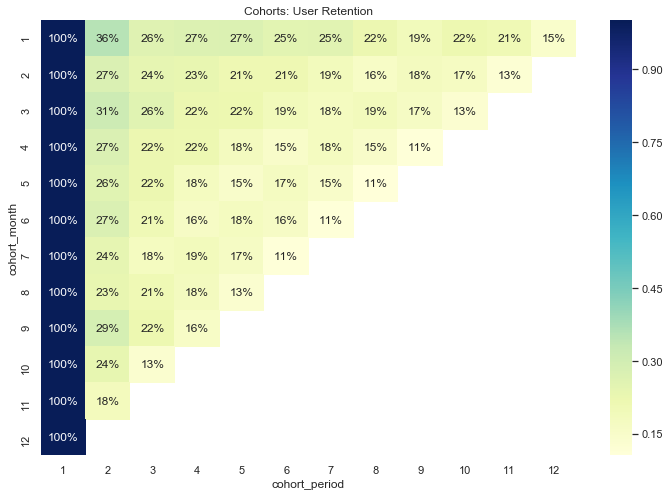

In [76]:
sns.set(style='white')
colormap = plt.cm.PuBu

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(df_retention_cohorts_pct.T, mask=df_retention_cohorts_pct.T.isnull(), annot=True, fmt='.0%', cmap='YlGnBu');

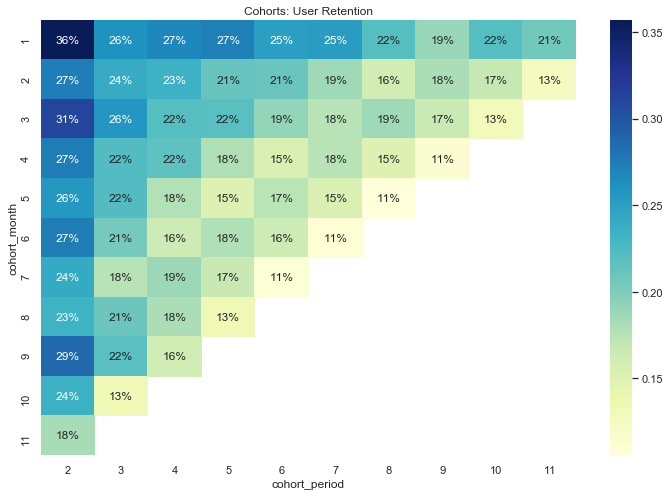

In [77]:
# 시작월 제외
sns.set(style='white')
colormap = plt.cm.PuBu

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(df_retention_cohorts_pct.T.iloc[0:11,1:11], mask=df_retention_cohorts_pct.T.iloc[0:11,1:11].isnull(), annot=True, fmt='.0%', cmap='YlGnBu');

- 특징
    1. retention 높은 편
    2. 3월 그룹, 9월 그룹 > 4,5,6 retention 높은편 **교통량 & holiday** 와 관련있어보임.
- **변수 활용방안 : 그룹별 pct 집계값?**
- join_date에도 동일하게 활용해볼 수 있을 듯

In [78]:
df_retention_cohorts_pct.T

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
1,1.0,0.356683,0.261189,0.267588,0.273041,0.249792,0.252745,0.221090,0.189777,0.220523,0.207573,0.147066
2,1.0,0.273339,0.240632,0.234169,0.211908,0.210928,0.186774,0.159943,0.180311,0.169278,0.125539,NaN
3,1.0,0.312237,0.256809,0.221155,0.219011,0.191694,0.175494,0.186373,0.165489,0.130628,NaN,NaN
4,1.0,0.274959,0.222671,0.215601,0.179396,0.153213,0.175666,0.151193,0.112423,NaN,NaN,NaN
5,1.0,0.256258,0.222471,0.177977,0.149834,0.174721,0.152872,0.105556,NaN,NaN,NaN,NaN
6,1.0,0.274922,0.205224,0.164224,0.178726,0.163921,0.110014,NaN,NaN,NaN,NaN,NaN
7,1.0,0.241216,0.176172,0.186977,0.167657,0.110912,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.233593,0.209454,0.181041,0.134691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.287442,0.218704,0.160881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Retention 활용방안 : 그룹별 집계값?

#### Join Date
- (5/11) Join date 삭제?

In [79]:
df['join_date'].dt.year.value_counts(sort=True)

2020    349473
2019    257603
2018    140523
2017     79938
2016     32701
2015     14946
2014      2957
1970      1093
2013        37
Name: join_date, dtype: int64

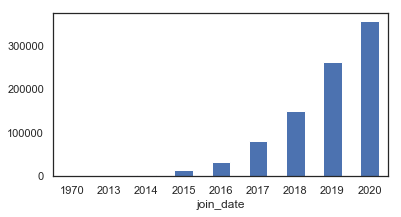

In [80]:
df_retention.groupby(df_retention['join_date'].dt.year)['count'].sum().plot(kind='bar', rot=0, figsize=(6,3))

In [81]:
print('join 년도 갯수 :', len(df_retention['join_date'].dt.year.unique()))
df_retention['join_date'].dt.year.unique()

join 년도 갯수 : 9


array([2013, 2014, 1970, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)